In [39]:
import torch
device = "cuda"
torch.set_printoptions(
    threshold=10_000_000,   # effectively infinite
    linewidth=1_000_000     # prevent wrapping
    
)
import matplotlib.pyplot as plt

In [40]:
GM = 16
GN = 16
n_tiles_total = GM*GN 
group_m = 4
group_n = 4
blocks_per_group = group_m*group_n 
g_outer_m = GM//group_m
g_outer_n = GN//group_n 
b = torch.arange(n_tiles_total, device = device)
two_d_map = torch.zeros(GM,GN,device=device, dtype = torch.long)

group_id = b // blocks_per_group;
local_id = b % blocks_per_group;

global_m = group_id // g_outer_n;
global_n = group_id % g_outer_n;

local_m = local_id // group_n;
local_n = local_id % group_n;


tile_m = global_m * group_m + local_m;
tile_n = global_n * group_n + local_n;


In [41]:
two_d_map[tile_m,tile_n] = b

In [42]:
two_d_map

tensor([[  0,   1,   2,   3,  16,  17,  18,  19,  32,  33,  34,  35,  48,  49,  50,  51],
        [  4,   5,   6,   7,  20,  21,  22,  23,  36,  37,  38,  39,  52,  53,  54,  55],
        [  8,   9,  10,  11,  24,  25,  26,  27,  40,  41,  42,  43,  56,  57,  58,  59],
        [ 12,  13,  14,  15,  28,  29,  30,  31,  44,  45,  46,  47,  60,  61,  62,  63],
        [ 64,  65,  66,  67,  80,  81,  82,  83,  96,  97,  98,  99, 112, 113, 114, 115],
        [ 68,  69,  70,  71,  84,  85,  86,  87, 100, 101, 102, 103, 116, 117, 118, 119],
        [ 72,  73,  74,  75,  88,  89,  90,  91, 104, 105, 106, 107, 120, 121, 122, 123],
        [ 76,  77,  78,  79,  92,  93,  94,  95, 108, 109, 110, 111, 124, 125, 126, 127],
        [128, 129, 130, 131, 144, 145, 146, 147, 160, 161, 162, 163, 176, 177, 178, 179],
        [132, 133, 134, 135, 148, 149, 150, 151, 164, 165, 166, 167, 180, 181, 182, 183],
        [136, 137, 138, 139, 152, 153, 154, 155, 168, 169, 170, 171, 184, 185, 186, 187],
        [1

In [43]:
import torch

def rotate_square_matrix(matrix, mode="left"):
    assert isinstance(matrix, torch.Tensor)
    assert matrix.ndim == 2

    n, m = matrix.shape
    assert n == m
    assert n > 0 and (n & (n - 1)) == 0
    assert mode in ("left", "right")

    device = matrix.device
    ROW = torch.arange(n, device=device)
    COL = torch.arange(n, device=device)

    # create grid indices
    i = ROW[:, None]   # shape (n,1)
    j = COL[None, :]   # shape (1,n)

    if mode == "left":      # CCW
        return matrix[j, i]
    else:                    # CW
        return matrix[n-1-j, n-1-i]

In [44]:
matrix = torch.arange(16,device =device, dtype = torch.int).reshape(4,4)

In [45]:
left_rot_matrix = rotate_square_matrix(matrix, mode="left")
right_rot_matrix = rotate_square_matrix(matrix, mode ="right")
print(matrix)
print(left_rot_matrix)
print(right_rot_matrix)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]], device='cuda:0', dtype=torch.int32)
tensor([[ 0,  4,  8, 12],
        [ 1,  5,  9, 13],
        [ 2,  6, 10, 14],
        [ 3,  7, 11, 15]], device='cuda:0', dtype=torch.int32)
tensor([[15, 11,  7,  3],
        [14, 10,  6,  2],
        [13,  9,  5,  1],
        [12,  8,  4,  0]], device='cuda:0', dtype=torch.int32)


In [46]:
def make_pseudo_hilbert_curve(order, start_offset=0):
    assert order >= 1

    if order == 1:
        # base 2x2
        return torch.tensor([
            [0, 3],
            [1, 2]
        ], dtype=torch.int) + start_offset

    prev = make_pseudo_hilbert_curve(order - 1, 0)
    n = prev.shape[0]
    block_size = n * n

    new_n = n * 2
    result = torch.empty((new_n, new_n), dtype=torch.int)

    # Quadrants
    Q0 = rotate_square_matrix(prev, "left")
    Q1 = prev.clone()
    Q2 = prev.clone()
    Q3 = rotate_square_matrix(prev, "right")

    result[0:n, 0:n] = Q0 + start_offset
    result[n:2*n, 0:n] = Q1 + start_offset + block_size
    result[n:2*n, n:2*n] = Q2 + start_offset + 2*block_size
    result[0:n, n:2*n] = Q3 + start_offset + 3*block_size

    return result
    

In [50]:
H = make_pseudo_hilbert_curve(4,start_offset=0)

In [57]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def draw_hilbert_curve(hilbert_tensor, show_grid=True, linewidth=2.0):
    assert isinstance(hilbert_tensor, torch.Tensor)
    assert hilbert_tensor.ndim == 2
    assert hilbert_tensor.shape[0] == hilbert_tensor.shape[1]

    t = hilbert_tensor.detach().cpu()
    n = t.shape[0]
    total = n * n

    # map index -> (col, row)
    coords = [None] * total
    for row in range(n):
        for col in range(n):
            idx = int(t[row, col])
            coords[idx] = (col, row)

    xs = np.array([c[0] for c in coords])
    ys = np.array([c[1] for c in coords])

    # --- Nord Colors ---
    bg_color = "#2E3440"
    grid_color = "#4C566A"
    text_color = "#D8DEE9"
    curve_colors = ["#88C0D0", "#81A1C1", "#5E81AC"]

    fig, ax = plt.subplots(figsize=(6, 6), facecolor=bg_color)
    ax.set_facecolor(bg_color)

    # Gradient along traversal
    for i in range(len(xs) - 1):
        ax.plot(
            xs[i:i+2],
            ys[i:i+2],
            color=curve_colors[i % len(curve_colors)],
            linewidth=linewidth
        )

    if show_grid:
        ax.set_xticks(range(n))
        ax.set_yticks(range(n))
        ax.grid(True, color=grid_color, linewidth=0.5)

    ax.set_aspect("equal")
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)

    ax.invert_yaxis()

    # Move x-axis to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Styling ticks
    ax.tick_params(colors=text_color)
    ax.spines[:].set_color(grid_color)

    ax.set_title(f"Hilbert Curve (n={n})", color=text_color, pad=20)

    plt.tight_layout()
    plt.show()

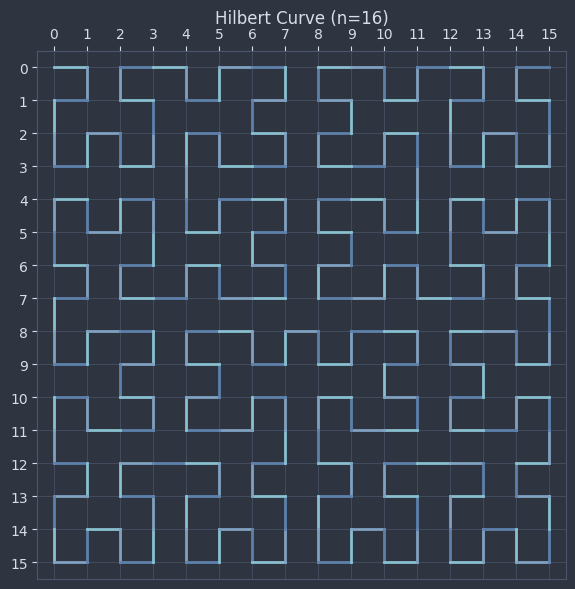

In [58]:
draw_hilbert_curve(H)